## Код для дипломной работы по теме:
## Факторная модель спредов на российском рынке корпоративных облигаций

In [71]:
import xlrd
import string
import pickle
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import mstats

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

import time
import pyautogui

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

from tqdm import tqdm, trange

from collections import Counter

## Открытие данных

In [72]:
oblig_discrip_data = pd.read_excel('Список облигаций - clean.xlsx', parse_dates=['Дата начала размещения',
                                                                                 'Дата окончания размещения',
                                                                                 'Дата погашения',
                                                                                 'Дата начала начисления купонов',
                                                                                 'Расчетная дата начала обращения',
                                                                                 'Дата регистрации',
                                                                                 'Дата торгов'])
oblig_discrip_data.sort_values("Дата регистрации", ascending=False, inplace=True)

oblig_discrip_data = oblig_discrip_data.loc[oblig_discrip_data['Дата регистрации'].dt.year >= 2012]
oblig_discrip_data = oblig_discrip_data.loc[oblig_discrip_data['Дата регистрации'].dt.year <= 2020]

# Удаляем две проблемные облигации
strange_bonds = ['Ипотечный агент Эклипс-1, класс Б', 'РОСБАНК, БО-12']
oblig_discrip_data = oblig_discrip_data.loc[~oblig_discrip_data.Бумага.isin(strange_bonds)]

# Добавляем ещё информацию о данных эмиссиях
extra_info_1 = pd.read_excel('bondsearch_14_04_2021-1.xlsx')
extra_info_2 = pd.read_excel('bondsearch_14_04_2021-2.xlsx')
extra_info_3 = pd.read_excel('bondsearch_14_04_2021-3.xlsx')
# extra_info_4 = pd.read_excel('bondsearch_14_04_2021-4.xlsx')
extra_info_1.shape, extra_info_2.shape, extra_info_3.shape #, extra_info_4.shape

extra_info = pd.concat([extra_info_1, extra_info_2, extra_info_3], axis=0)
extra_info.drop_duplicates(inplace=True)
set(extra_info.columns).intersection(set(oblig_discrip_data.columns))

extra_info.drop(columns=['Биржа', 'Бумага', 'Периодичность выплаты купонов', 'Эмитент'], inplace=True)
oblig_discrip_data = oblig_discrip_data.merge(extra_info, on=['ISIN'], how='left')

oblig_discrip_data.drop(columns=['Рейтинг эмитента в ин.валюте M/S&P/F', 'Рейтинг эмиссии в ин.валюте M/S&P/F', 
                                 'Рейтинг эмитента в нац.валюте M/S&P/F', 'Рейтинг эмиссии в нац.валюте M/S&P/F', 
                                 'Дата начала размещения', 'Дата окончания размещения', 
                                 'Начало размещения', 'Окончание размещения', '№ old', 
                                 'Дата оферты (put)', 'Дата оферты (call)', 'Дата торгов', 'Статус эмиссии'],
                        inplace=True)

# Открываем таблицу со списком компании
company_data = pd.read_excel('Список компаний.xlsx', parse_dates=['Дата регистрации'])
company_data = company_data.loc[company_data['Дата регистрации'].dt.year >= 2012]
company_data = company_data.loc[company_data['Дата регистрации'].dt.year <= 2020]

# Открываем панель
prep_weekly_data = pd.read_pickle('prep_weekly_data.pkl')

oblig_discrip_data.shape, company_data.shape, prep_weekly_data.shape

((4237, 36), (616, 4), (40500, 64))

In [3]:
market_volume = pd.read_excel('Объём рынка.xlsx', skiprows=1, nrows=31).drop(
    columns=['ID', 'Единица измерения']).set_index('Наименование').T.reset_index().rename(columns={'index': 
                                                                                                   'date'})
market_volume.head(2)

Наименование,date,Облигации Министерства Финансов,Облигации Банка России,Муниципальные облигации,Субъекты Федерации,Муниципальные образования,Муниципальный облигации (по непогашенному номиналу),Корпоративные облигации,АПК и сельское хозяйство,Банки,Горнодобывающая пром.,Легкая пром.,Машиностроение,Нефтегазовая отрасль,Пищевая пром.,Связь и телекоммуникации,Строительство и девелопмент,Торговля и ритэйл,Транспорт,Финансовые институты,Химическая и нефтехимическая пром.,Цветная металлургия,Черная металлургия,Другие отрасли,Корпоративные облигации (по непогашенному номиналу),Рыночные корпоративные облигации,Новые выпуски,Аукционы ГКО-ОФЗ,Аукционы КОБР,Новые выпуски муниципальных облигаций,Новые выпуски корпоративных облигаций,Новые выпуски рыночных корпоративных облигаций
0,2011-04-29,2818.05,Нет данных,448.924,438.474,10.45,440.781,3221.51,17.4328,749.736,39.82,0,122.68,369.503,66.7326,230.988,95.3984,88.913,264.3,348.059,191.842,52.4,222.2,150.274,3468.01,2963.72,NaN,71.5172,Нет данных,1.822,116.71,115.157
1,2011-05-31,2931.8,Нет данных,452.045,441.595,10.45,446.911,3234.19,20.4328,750.736,39.82,0,143.771,369.503,64.7326,230.986,92.5984,84.613,264.3,345.379,199.342,52.4,221,141.353,3500.55,2956.98,NaN,78.2495,Нет данных,8,40.0911,19


In [4]:
# plt.figure(figsize=(15, 8))
# sns.lineplot(x=market_volume.date, y=market_volume['Облигации Министерства Финансов'].astype(int), 
#              label='Облигации Министерства Финансов')
# # sns.lineplot(x=market_volume.date, y=market_volume['Муниципальные облигации'].astype(int))
# sns.lineplot(x=market_volume.date, y=market_volume['Корпоративные облигации'].astype(int), 
#              label='Корпоративные облигации')
# sns.lineplot(x=market_volume.date, y=market_volume['Рыночные корпоративные облигации'].astype(int), 
#              label='Рыночные корпоративные облигации')
# plt.xlabel('Год', fontsize=13)
# plt.ylabel('Млрд. руб.', fontsize=13)
# plt.title('Тенденция к расширению рынка облигаций', fontsize=15)
# plt.legend(loc=2, prop={'size': 15})
# plt.show()

In [5]:
# plt.figure(figsize=(15, 8))
# for col in ['Банки', 'Нефтегазовая отрасль', 'Связь и телекоммуникации', 'Транспорт', 'Финансовые институты']:
    
#     sns.lineplot(x=market_volume.date, y=market_volume[col].astype(int), label=col)
    
# plt.xlabel('Год', fontsize=13)
# plt.ylabel('Млрд. руб.', fontsize=13)
# plt.title('Топ 5 отраслей по выпуску облигаций', fontsize=15)
# plt.legend(loc=2, prop={'size': 15})
# plt.show()

In [12]:
# prep_weekly_data.loc[:, ['bid_ask_bp', 'close_price', 
#                          'turnover', 'g_spread_bp', 'issuance']].describe().round(2).to_excel('descriptive.xlsx')

In [7]:
prep_weekly_data.drop_duplicates(subset='bond').sector.value_counts(normalize=True)

Банки            0.661568
Связь/телеком    0.084130
Энергетика       0.057361
Нефть и газ      0.051625
Торговля         0.026769
Черная метал.    0.022945
Строительство    0.021033
Хим/нефтехим     0.019120
Горнодобыча      0.017208
Пищевая пром     0.015296
Машиностр        0.015296
Транспорт        0.005736
Цвет. метал.     0.001912
Name: sector, dtype: float64

In [8]:
prep_weekly_data.drop_duplicates(subset='bond').groupby('sector').company.value_counts(normalize=True)

sector         company                          
Банки          Сбербанк России                      0.583815
               ВТБ                                  0.332370
               Московский кредитный банк            0.063584
               РОСБАНК                              0.020231
Горнодобыча    АЛРОСА                               0.777778
               Полюс                                0.222222
Машиностр      КАМАЗ                                0.875000
               ИРКУТ                                0.125000
Нефть и газ    Роснефть                             0.518519
               Газпром нефть                        0.259259
               Башнефть                             0.148148
               Татнефть                             0.037037
               ЯТЭК                                 0.037037
Пищевая пром   Белуга Групп                         0.500000
               Группа Черкизово                     0.500000
Связь/телеком  АФК Система          

In [9]:
prep_weekly_data.rating.value_counts(dropna=False, normalize=True)

NaN          0.475333
AAA(RU)      0.389654
AA(RU)       0.054494
A(RU)        0.048469
A+(RU)       0.020914
Withdrawn    0.009926
A-(RU)       0.001210
Name: rating, dtype: float64

In [16]:
# sns.set_theme(style="darkgrid")
# plt.figure(figsize=(15, 7))
# sns.countplot(data=prep_weekly_data, x='year_num')
# plt.xlabel('Год', fontsize=13)
# plt.ylabel('Количество наблюдений', fontsize=13)
# plt.title('Тенденция к расширению рынка корпоративных облигаций', fontsize=15)
# plt.show()

In [17]:
prep_weekly_data.columns

Index(['date', 'bid', 'ask', 'bid_ask_bp', 'market_price', 'admitted_price',
       'close_price', 'indicative', 'turnover', 'num_of_deals',
       'turnover_in_securities', 'current_coupon', 'ytm_ind_p', 'ytm_close_p',
       'accrued_interest', 'duration', 'mod_duration', 'ytm_oferta_ind_p',
       'ytm_oferta_close_p', 'dur_to_p_c_date', 'mod_dur_to_p_c_date',
       'g_spread_bp', 'exchange', 'indicative_type', 'maturity',
       'put_call_date', 'bond', 'cum_count', 'counted_vals', 'company',
       'sector', 'year_num', 'quarter_num', 'month_num', 'week_num',
       'issuance', 'reg_date', 'days_left', 'days_passed', 'turnover_norm',
       'prop_bid_ask', 'yield2y', 'yield10y', 'moex', 'moex_ret', 'brent',
       'ref_rate', 'usdrub', 'slope', 'rating', 'rating_num', 'rating_cut',
       'liab_current', 'liab_noncurrent', 'default_point', 'close',
       'daily_ret', 'trading_volume', 'variance', 'num_of_stocks', 'cap',
       'dist_to_default', 'prop_of_default', 'illiquidity']

In [23]:
prep_weekly_data['year_month'] = prep_weekly_data.year_num.astype(str) +"-"+ prep_weekly_data.month_num.astype(str)

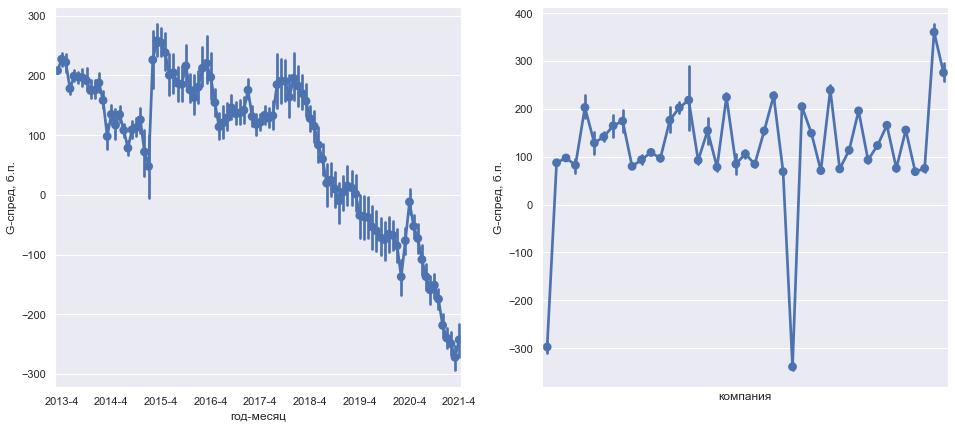

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.pointplot(x="year_month", y="g_spread_bp", data=prep_weekly_data.sort_values('date'), ci=99, ax=ax[0])
ax[0].xaxis.set_ticks(np.arange(1, 100, 12))
ax[0].set_xlabel("год-месяц")
ax[0].set_ylabel("G-спред, б.п.")

sns.pointplot(x="company", y="g_spread_bp", data=prep_weekly_data.sort_values('date'), ci=99, ax=ax[1])
ax[1].set_xticks([])
ax[1].set_xlabel("компания")
ax[1].set_ylabel("G-спред, б.п.")
plt.show()

In [48]:
prep_weekly_data.groupby("company")['g_spread_bp'].mean().sort_values()

company
Сбербанк России                     -339.079734
ВТБ                                 -297.751383
ГМК Норильский никель                 68.737684
МТС                                   68.776307
Газпром нефть                         70.943591
Ростелеком                            74.420260
Татнефть                              75.611812
Северсталь                            75.882593
МегаФон                               78.215606
Роснефть                              79.888735
АЛРОСА                                82.210033
ОГК-2                                 84.504963
Московский кредитный банк             84.602886
РусГидро                              87.356389
РОСБАНК                               92.357117
ТрансКонтейнер                        93.223810
ФСК ЕЭС                               93.702601
Башнефть                              96.763488
Магнит                                97.386589
Полюс                                105.861578
Акрон                           

In [51]:
prep_weekly_data.bond.nunique(), prep_weekly_data.company.nunique(), prep_weekly_data.sector.nunique()

(523, 43, 13)

In [57]:
translation_1 = {'Дата торгов': 'date', 
                 'Название биржи': 'exchange',
                 'Котировка на покупку, закрытие (bid), %': 'bid',
                 'Котировка на продажу, закрытие (ask), %': 'ask',
                 'Bid-ask спред, б.п.': 'bid_ask_bp',
                 'Рыночная цена, %': 'market_price',
                 'Признаваемая котировка, %': 'admitted_price',
                 'Цена закрытия, %': 'close_price',
                 'Индикативная цена, %': 'indicative',
                 'Тип индикативной цены': 'indicative_type',
                 'Оборот': 'turnover',
                 'Количество сделок': 'num_of_deals',
                 'Объем сделок в бумагах': 'turnover_in_securities',
                 'Текущая ставка купона, %': 'current_coupon',
                 'Дата погашения': 'maturity',
                 'Доходность к погашению по инд. цене, %': 'ytm_ind_p',
                 'Доходность к погашению по цене закрытия, %': 'ytm_close_p',
                 'НКД': 'accrued_interest', 
                 'Дюрация': 'duration',
                 'Модифицированная дюрация': 'mod_duration',
                 'Дата оферты (put/call)': 'put_call_date',
                 'Доходность к оферте по инд. цене, %': 'ytm_oferta_ind_p',
                 'Доходность к оферте по цене закрытия, %': 'ytm_oferta_close_p',
                 'Дюрация к оферте': 'dur_to_p_c_date',
                 'Модифицированная дюрация к оферте': 'mod_dur_to_p_c_date',
                 'G-spread, б.п.': 'g_spread_bp'
              }

In [70]:
pd.DataFrame(prep_weekly_data.count().reset_index()).merge(
    pd.DataFrame(translation_1.items()), left_on="index", right_on=1, how='left'
).iloc[:, :3].rename(columns={'index': 'Сокращение (на англ.)', 
                              '0_x': 'Количество непустых',
                              '0_y': 'Полное название'}).to_excel('all_vars.xlsx')